In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")



/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


# Trading on earnings suprises (when using midpoint) is not super informative... buy days do slighly better than sell days

# Both buy and sell have high SR of 0.8-0.9 (on 20%+ returns) but low IR of 0.2 (on 2% alpha)

In [2]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data

,tradedate,osid,symbol,coname,sector_group,max_dt,previoustradedate,tickssinceipo,alpha,stdev_alpha,...,ret1d_lag,alpha1d_lag,ret5d_lag,alpha5d_lag,ret10d_lag,alpha10d_lag,ret15d_lag,alpha15d_lag,ret20d_lag,alpha20d_lag
0,19950103,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19941230.0,8056,0.010006,0.004670,...,0.00000,-0.003112,0.176850,0.166677,0.131841,0.102035,0.144700,0.123317,0.138261,0.106187
1,19950104,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950103.0,8057,-0.003112,0.004656,...,0.01929,0.019820,0.131835,0.124719,0.125412,0.099894,0.173638,0.151438,0.144692,0.115932
2,19950105,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950104.0,8058,0.019820,0.005805,...,0.04732,0.045571,0.119876,0.112258,0.094651,0.075155,0.170357,0.145504,0.135652,0.101416
3,19950106,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950105.0,8059,0.045571,0.009709,...,0.03313,0.032296,0.069278,0.054748,0.063264,0.050293,0.096391,0.070299,0.090370,0.047479
4,19950109,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950106.0,8060,0.032296,0.010892,...,0.06706,0.063220,0.058317,0.037605,0.020420,0.006697,0.046651,0.026290,0.072892,0.026535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912427,20210805,78696,COOK,Traeger Inc,7.0,20210805,20210804.0,6,0.047968,0.026349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912428,20210806,78722,WEBR,Weber Inc Cl A,NaN,20210809,20210805.0,2,0.000000,0.000000,...,0.08190,0.080042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912429,20210809,78722,WEBR,Weber Inc Cl A,7.0,20210809,20210806.0,3,0.080042,0.025773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912430,20210901,78803,FCUV,Focus Universal Inc,NaN,20210902,20210831.0,2,0.000000,0.000000,...,-0.07106,-0.072293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Midpoint Analyst Estimate = (epshigha1 + epslowa1) / 2

### Now, let's trade on earnings suprises!
### the times when 'epsa1' > ('epshigha1' + epslowa1) / 2
###### Buy when positive suprise, so when df['epsa1'] > df['midpoint']
###### Sell when negative suprise, so when df['epsa1'] < df['midpoint']
### with 1 day, 1 week, 2 weeks, 3 weeks, and 4 weeks holding period 
### (AHEAD, not backward... so our ret, ret5d, 10d, 15d, and 20d needs to be forward)
### Thus, we will use ret5d_'lag' !!

# Set buy_tomorrow>0 when df['epsa1'] > df['midpoint']  
### ie earnings falls above MID ESTIMATE!
# Set Sell_tomorrow>0 when df['epsa1'] < df['midpoint']
### ie earnings falls below MID ESTIMATE!

In [3]:
K = 10 # Number of deciles to create!
#####################################################################################
#####################################################################################
#NOTE: K=10 is preset for 'summary_stats_bull_OR_bear' ... ONLY K=10 will work for 'summary_stats_bull_OR_bear'
#NOTE: 'create_quantiles' & 'summary_stats_plots' can work with any K
#####################################################################################
#####################################################################################

df = data.copy()

#create signal below:
df['aux_signal'] = df['ret10d']

#DROP MISSING AUX_SIGNALS below:
df = df.loc[df['aux_signal'].notna(),:].reset_index(drop=True).copy()

########################################################################
########################################################################
def create_quantiles(df):  #CAN HANDLE ANY GENERIC K (global variable K defined above ^) !!!
    brkpts = df.groupby(['tradedate'])['aux_signal'].quantile([1/K]).to_frame().reset_index()\
                        .rename(columns={'aux_signal':'brk1'}).drop(columns=['level_1']) #rename aux_signal and drop col

    for i in range(2,K):
        current_label = f'brk{i}'  #new brk
        brkpts = pd.merge(brkpts,df.groupby(['tradedate'])['aux_signal'].quantile([i / K]).to_frame()\
                              .reset_index().rename(columns={'aux_signal':current_label})\
                              .drop(columns=['level_1']),how='left',on=['tradedate']) ##merge 'brkpts' with a new #for each week, qcut aux_signal==Ranking_Ret into i/10, rename aux_signal and drop col
    #each day has its own breakpoint depending on which level of signal are required to be in that bin

    # Merging breakpoints back to panel data
    df = pd.merge(df, brkpts, how='left', on='tradedate')  #merge on day
    
    # Defining portfolios bins
    df['bin'] = np.nan

    df.loc[df['aux_signal'] <= df['brk1'],'bin'] = 1  #if aux_signal<1st brkpt --> then bin=1
    for i in range(2,K): #do the same for all other breakpoints in the dataframe (k=10 brkpts), so i=2,...,k-1
    #         print(str(i)+', ',end="")
        df.loc[(df['aux_signal'] > df[f'brk{i-1}']) 
                   & (df['aux_signal'] <= df[f'brk{i}']),'bin'] = i #falls in ith bin
    df.loc[df['aux_signal'] > df['brk'+str(K-1)],'bin'] = K #last bin

    for i in range(1,K):
        df = df.drop([f'brk{i}'], axis=1) #no longer need the breakpoints (just need the bin#)

    df.drop('aux_signal',axis=1,inplace=True)
    df = df.reset_index().rename(columns={"bin":"decile"}).copy()
    #DEPENDING ON IN BETWEEN WHICH BREAKPOINT THE aux_signal FALLS, THAT IS THE BIN THAT THAT STOCK BELONGS TO ON THAT DAY

    return df
########################################################################
########################################################################

df = create_quantiles(df) #CAN HANDLE ANY GENERIC K (global variable K defined above ^) !!!
df = df.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()
df
data = df.copy()
data


,index,tradedate,osid,symbol,coname,sector_group,max_dt,previoustradedate,tickssinceipo,alpha,...,alpha1d_lag,ret5d_lag,alpha5d_lag,ret10d_lag,alpha10d_lag,ret15d_lag,alpha15d_lag,ret20d_lag,alpha20d_lag,decile
0,0,19950116,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950113.0,8065,0.015518,...,-0.032088,-0.035809,-0.029788,-0.011023,-0.010905,0.013772,-0.010669,0.049577,0.023018,10.0
1,1,19950117,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950116.0,8066,-0.032088,...,-0.005049,0.011362,0.019311,0.005672,0.003767,0.056813,0.033826,0.065326,0.038353,9.0
2,2,19950118,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950117.0,8067,-0.005049,...,-0.003118,0.042852,0.046862,0.017131,0.014581,0.074276,0.049430,0.077122,0.045247,9.0
3,3,19950119,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950118.0,8068,-0.003118,...,0.021392,0.069159,0.065431,0.037455,0.024425,0.086444,0.057519,0.080664,0.041594,8.0
4,4,19950120,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950119.0,8069,0.021392,...,-0.010553,0.031156,0.019048,0.025493,-0.002679,0.062308,0.027360,0.042464,0.006933,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894083,2894083,20210827,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210826.0,20,-0.030882,...,-0.029899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2894084,2894084,20210830,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210827.0,21,-0.029899,...,-0.007836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2894085,2894085,20210831,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210830.0,22,-0.007836,...,0.021886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2894086,2894086,20210901,78691,VSCO,Victoria's Secret & Co,7.0,20210902,20210831.0,23,0.021886,...,-0.028671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [4]:
data['report_date'] = pd.to_datetime(data['reportdate'], format='%Y%m%d', errors='ignore')


data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data[data['epsa1'].notna()].reset_index(drop=True).copy()
data = data[data['epshigha1'].notna()].reset_index(drop=True).copy()
data = data[data['epslowa1'].notna()].reset_index(drop=True).copy()
#data = data[data['ret10d'].notna()].reset_index(drop=True).copy()
data = data[data['decile'].notna()].reset_index(drop=True).copy() #using the 10 day MOM decile of the stock!
data = data[data['report_date'].notna()].reset_index(drop=True).copy()


data['midpoint'] = (data['epshigha1']+data['epslowa1']) / 2

data['earnings_delta_surprise'] = (data['epsa1']-data['midpoint'])/data['midpoint'] #(Actual - midpoint)/midpoint predicted

data = data[data['earnings_delta_surprise'].notna()].reset_index(drop=True).copy()

data['buy_tomorrow1'] = np.where(data['earnings_delta_surprise']>0.05, 1, 0)
data['sell_tomorrow1'] = np.where(data['earnings_delta_surprise']<-0.05, 1, 0)

#data['buy_tomorrow2'] = np.where(data['ret10d'] > 0.025, 1, 0)
#data['sell_tomorrow2'] = np.where(data['ret10d'] < -0.025, 1, 0)
data['buy_tomorrow2'] = np.where(data['decile'] > 8, 1, 0) #decile 9 or decile 10 (high past ret10d)
data['sell_tomorrow2'] = np.where(data['decile'] < 3, 1, 0) ##decile 1 or decile 2 (low past ret10d)

data['buy_tomorrow3'] = np.where( (data['date']-data['report_date']).dt.days == 1, 1, 0)
data['sell_tomorrow3'] = np.where( (data['date']-data['report_date']).dt.days == 1 , 1, 0)

data['buy_tomorrow'] = data['buy_tomorrow1'] + data['buy_tomorrow2'] + data['buy_tomorrow3']
data['sell_tomorrow'] = data['sell_tomorrow1'] + data['sell_tomorrow2'] + data['sell_tomorrow3']

data['buy_tomorrow'] = np.where(data['buy_tomorrow']==3, 1, 0)
data['sell_tomorrow'] = np.where(data['sell_tomorrow']==3, 1, 0)



print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'


Total number of Buys:  746
Total number of Sells:  744
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [5]:
data = cp.trade_on_valid_lags_only(data)


There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  746
Total number of Sells:  744


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [6]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)


There are  3  problems for buying

There are  1  problems for selling
Total number of Buys:  14801
Total number of Sells:  14809

There are  3  problems for buying

There are  1  problems for selling
Total number of Buys:  11120
Total number of Sells:  11126

There are  2  problems for buying

There are  0  problems for selling
Total number of Buys:  7423
Total number of Sells:  7427

There are  2  problems for buying

There are  0  problems for selling
Total number of Buys:  3718
Total number of Sells:  3717

There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  745
Total number of Sells:  744


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9283
Date:                Mon, 06 Dec 2021   Prob (F-statistic):              0.474
Time:                        23:30:47   Log-Likelihood:                 1134.8
No. Observations:                 588   AIC:                            -2256.
Df Residuals:                     581   BIC: 

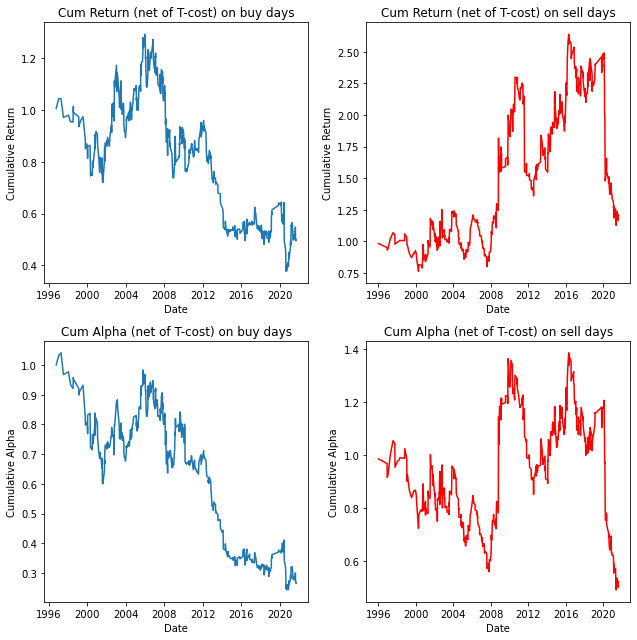

In [7]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.471
Date:                Mon, 06 Dec 2021   Prob (F-statistic):             0.0220
Time:                        23:31:02   Log-Likelihood:                 4236.1
No. Observations:                2056   AIC:                            -8458.
Df Residuals:                    2049   BIC: 

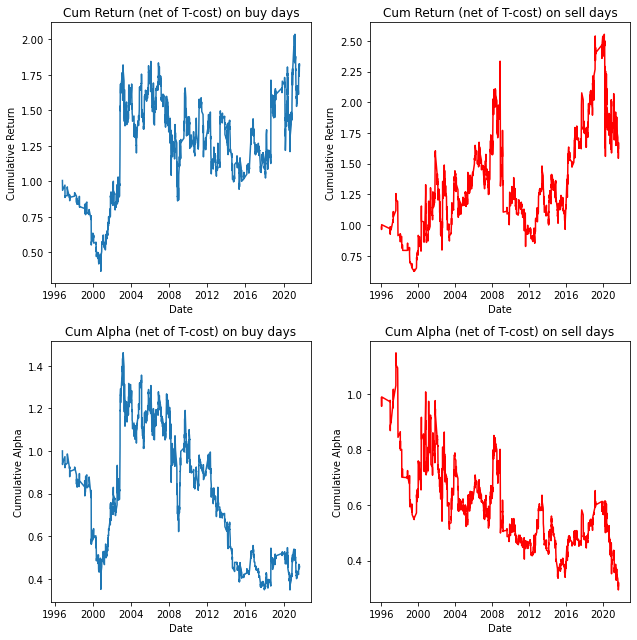

In [8]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.043
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           0.000484
Time:                        23:31:16   Log-Likelihood:                 6619.5
No. Observations:                3086   AIC:                        -1.322e+04
Df Residuals:                    3079   BIC: 

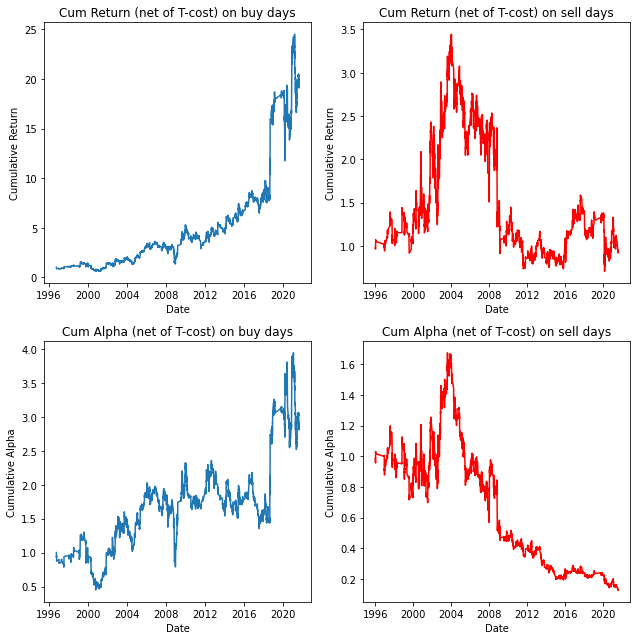

In [9]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.951
Date:                Mon, 06 Dec 2021   Prob (F-statistic):            0.00710
Time:                        23:31:31   Log-Likelihood:                 8020.4
No. Observations:                3803   AIC:                        -1.603e+04
Df Residuals:                    3796   BIC: 

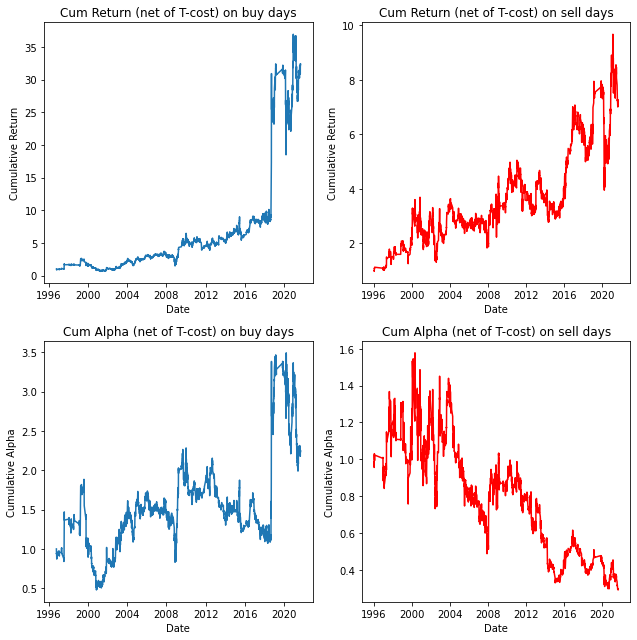

In [10]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.224
Date:                Mon, 06 Dec 2021   Prob (F-statistic):            0.00367
Time:                        23:31:47   Log-Likelihood:                 9188.6
No. Observations:                4346   AIC:                        -1.836e+04
Df Residuals:                    4339   BIC: 

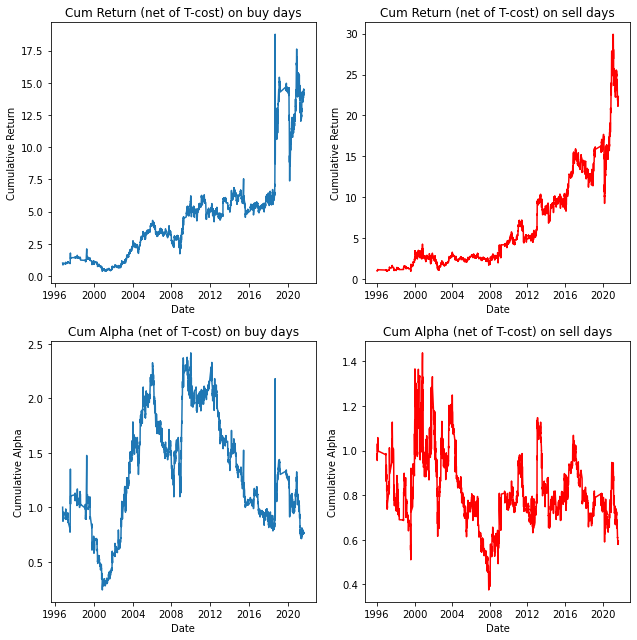

In [11]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)

# Repeat but for difference in date to be 0 in buy_tomorrow2/sell_tomorrow2 condition

In [12]:
data = df.copy()

data['report_date'] = pd.to_datetime(data['reportdate'], format='%Y%m%d', errors='ignore')


data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data[data['epsa1'].notna()].reset_index(drop=True).copy()
data = data[data['epshigha1'].notna()].reset_index(drop=True).copy()
data = data[data['epslowa1'].notna()].reset_index(drop=True).copy()
#data = data[data['ret10d'].notna()].reset_index(drop=True).copy()
data = data[data['decile'].notna()].reset_index(drop=True).copy() #using the 10 day MOM decile of the stock!
data = data[data['report_date'].notna()].reset_index(drop=True).copy()


data['midpoint'] = (data['epshigha1']+data['epslowa1']) / 2

data['earnings_delta_surprise'] = (data['epsa1']-data['midpoint'])/data['midpoint'] #(Actual - midpoint)/midpoint predicted

data = data[data['earnings_delta_surprise'].notna()].reset_index(drop=True).copy()

data['buy_tomorrow1'] = np.where(data['earnings_delta_surprise']>0.05, 1, 0)
data['sell_tomorrow1'] = np.where(data['earnings_delta_surprise']<-0.05, 1, 0)

#data['buy_tomorrow2'] = np.where(data['ret10d'] > 0.025, 1, 0)
#data['sell_tomorrow2'] = np.where(data['ret10d'] < -0.025, 1, 0)
data['buy_tomorrow2'] = np.where(data['decile'] > 8, 1, 0) #decile 9 or decile 10 (high past ret10d)
data['sell_tomorrow2'] = np.where(data['decile'] < 3, 1, 0) ##decile 1 or decile 2 (low past ret10d)

data['buy_tomorrow3'] = np.where( (data['date']-data['report_date']).dt.days == 0, 1, 0)
data['sell_tomorrow3'] = np.where( (data['date']-data['report_date']).dt.days == 0 , 1, 0)

data['buy_tomorrow'] = data['buy_tomorrow1'] + data['buy_tomorrow2'] + data['buy_tomorrow3']
data['sell_tomorrow'] = data['sell_tomorrow1'] + data['sell_tomorrow2'] + data['sell_tomorrow3']

data['buy_tomorrow'] = np.where(data['buy_tomorrow']==3, 1, 0)
data['sell_tomorrow'] = np.where(data['sell_tomorrow']==3, 1, 0)



print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'



Total number of Buys:  490
Total number of Sells:  498
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [13]:
data = cp.trade_on_valid_lags_only(data)

data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)


There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  490
Total number of Sells:  498

There are  2  problems for buying

There are  1  problems for selling
Total number of Buys:  9722
Total number of Sells:  9781

There are  2  problems for buying

There are  1  problems for selling
Total number of Buys:  7304
Total number of Sells:  7348

There are  2  problems for buying

There are  0  problems for selling
Total number of Buys:  4879
Total number of Sells:  4907

There are  1  problems for buying

There are  0  problems for selling
Total number of Buys:  2440
Total number of Sells:  2457

There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  489
Total number of Sells:  496



There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.367
Date:                Mon, 06 Dec 2021   Prob (F-statistic):            0.00298
Time:                        23:34:02   Log-Likelihood:                 457.47
No. Observations:                 420   AIC:                            -900.9
Df Residuals:                     413   BIC: 

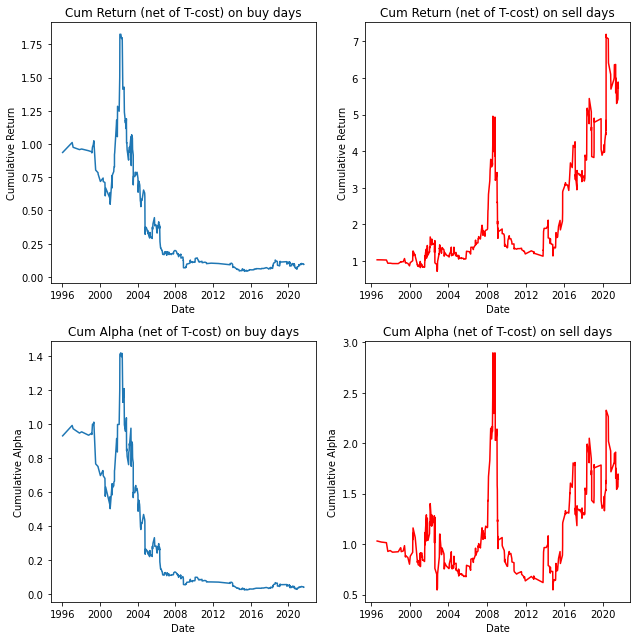

In [14]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.828
Date:                Mon, 06 Dec 2021   Prob (F-statistic):             0.0901
Time:                        23:34:17   Log-Likelihood:                 2566.4
No. Observations:                1549   AIC:                            -5119.
Df Residuals:                    1542   BIC: 

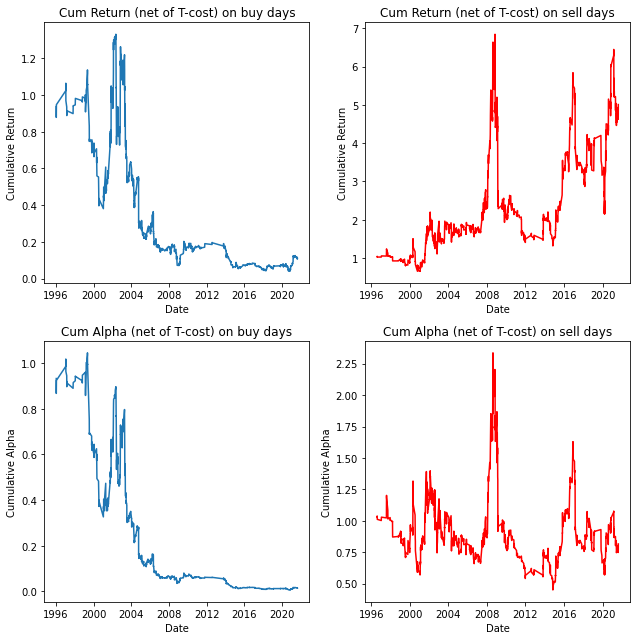

In [15]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.085
Date:                Mon, 06 Dec 2021   Prob (F-statistic):             0.0520
Time:                        23:34:31   Log-Likelihood:                 4432.7
No. Observations:                2385   AIC:                            -8851.
Df Residuals:                    2378   BIC: 

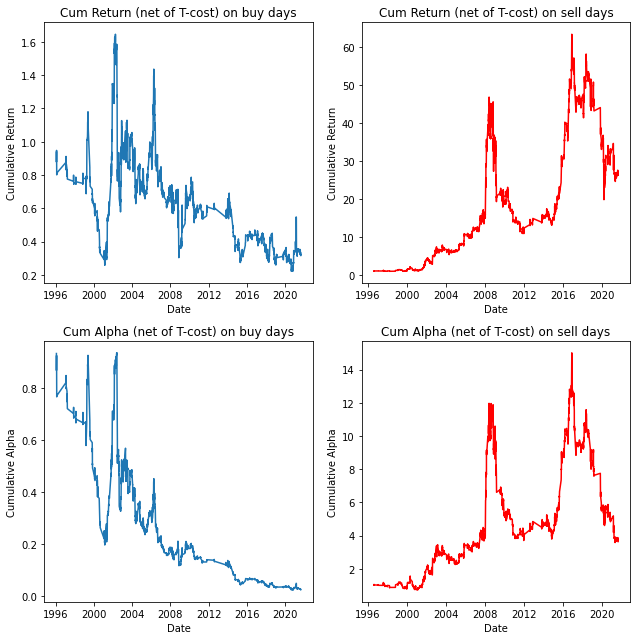

In [16]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.930
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           4.99e-05
Time:                        23:34:46   Log-Likelihood:                 5811.7
No. Observations:                3011   AIC:                        -1.161e+04
Df Residuals:                    3004   BIC: 

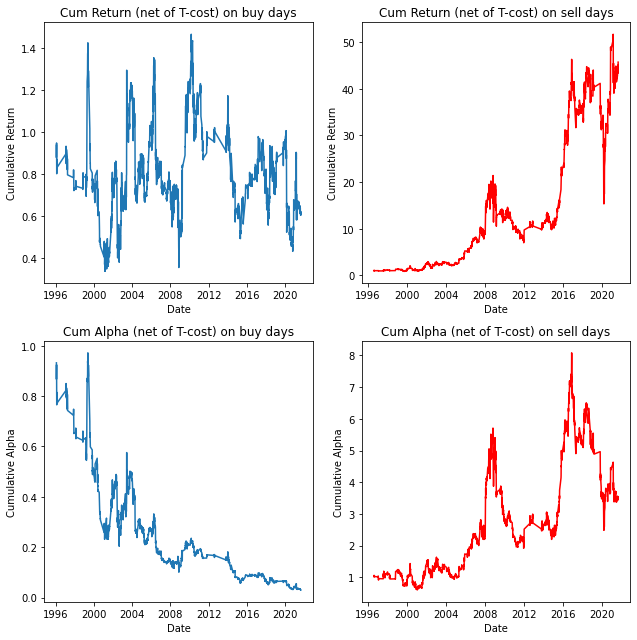

In [17]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.352
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           0.000220
Time:                        23:35:01   Log-Likelihood:                 7059.9
No. Observations:                3501   AIC:                        -1.411e+04
Df Residuals:                    3494   BIC: 

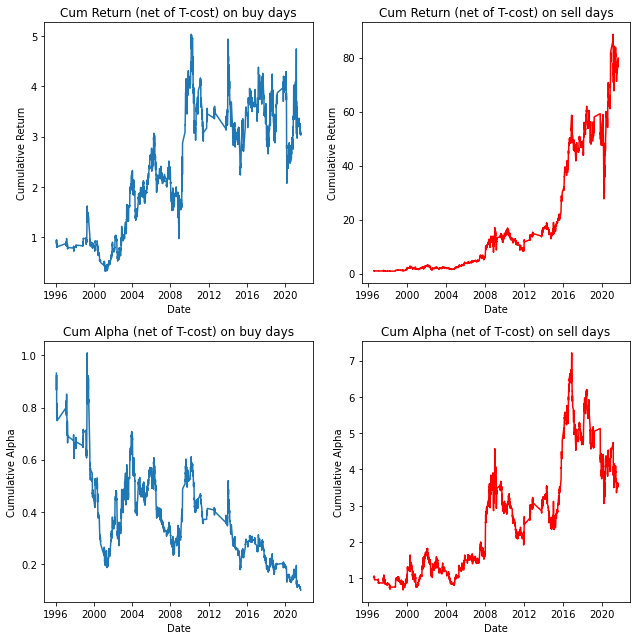

In [18]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)